# Part 2 : Building the modular network

### Overview

This Notebook continues where Part 2 left. We work with the original paper once again, but this rebuilding the modular network.

### Chapters


### 0. Plot configuration


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

%load_ext autoreload
%autoreload 2

plt.style.use(["science"])
plt.rcParams["figure.figsize"] = (8, 8)

## 1. Building the network


In [2]:
import nest
import nest.raster_plot
import pylab

nest.ResetKernel()
n = 4  # number of threads'
dt = 0.1

nest.SetKernelStatus(
    {"local_num_threads": n, "resolution": dt, "overwrite_files": True}
)

nest.SetKernelStatus({"print_time": True})

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Mar  7 2023 05:58:34

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Apr 04 01:41:24 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


### 1a. Model parameters


In [3]:
N_total = 1_600 * 3
n_submodules = 16

E_perc = 4 / 5
N_E = int(N_total * E_perc)  # Number of excitatory neurons
N_I = int(N_total * (1 - E_perc))  # Number of excitatory neurons
N_rec = N_E  # Number of neurons to record

In [4]:
neuron_model = "iaf_cond_exp"

neuron_params = {
    "V_m": -60.0,
    "E_L": -60.0,
    "V_th": -50.0,
    "V_reset": -60.0,
    "t_ref": 5.0,
    "E_ex": 0.0,
    "E_in": -80.0,
    "C_m": 100.0,
    "g_L": 10.0,
    # "I_e": 50.0,
    "tau_syn_ex": 5.0,
    "tau_syn_in": 10.0,
}

# Synapse parameters
P_0 = 0.08  # Connection probability
delay = 1.0

J_E = 0.5
J_I = -0.8

# Stimulation
p_rate = 10_000

In [5]:
nest.CopyModel(
    "static_synapse",
    "excitatory_synapse",
    {
        "weight": J_E,
        "delay": delay,
    },
)

nest.CopyModel(
    "static_synapse",
    "inhibitory_synapse",
    {
        "weight": J_I,
        "delay": delay,
    },
)

### 1b. Building the modular network


What we now want to do is to take the same number of _total_ neurons as before, but change their topology by rewiring connections. Something like the follow figure:

<img src="./../img/neural_columns.png" width="600">

The paper uses a recursive method for splitting the random network into submodules, where

- inhibitory synapses are always rewired within the module
- excitatory synapses are rewired within with the probability $R_{ex}$,

The paper also provides a formula for computing inter-modular connection probabilities:

Splitting a module into $m$ submodules of equal size at each level, the connection density between the modules of the $i$ th level is:

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_n/fncom-05-00030-e006.gif" width="500">

where $i = 1,…,l$, if a network is rewiring into a l-level HMN. The connection density within each unit of the network, that is, the l-level module, is

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_n/fncom-05-00030-e007.gif" width="500">


**Generate base network**


In [6]:
def configure_submodule(submodule, nodes, E_perc):
    """Configures and connects a submodule"""
    submodule_len = len(submodule)
    N_E = int(submodule_len * E_perc)
    nodes_E = submodule[:N_E]
    nodes_I = submodule[N_E:]

    print(
        f"Connecting {len(nodes_E)} exc. nodes, {len(nodes_I)} inh. nodes, into {len(nodes)}"
    )

    prob_conn_dict = {"rule": "pairwise_bernoulli", "p": P_0}

    nest.Connect(
        nodes_E,
        nodes,
        syn_spec={"synapse_model": "excitatory_synapse"},
        conn_spec=prob_conn_dict,
    )
    nest.Connect(
        nodes_I,
        nodes,
        syn_spec={"synapse_model": "inhibitory_synapse"},
        conn_spec=prob_conn_dict,
    )
    print("- Configured nodes.")


def generate_base_network(nodes, n_modules, E_perc):
    n_of_nodes = len(nodes)
    len_submodule = int(n_of_nodes // n_modules)
    print(
        f"Generating submodules of size {len_submodule}, total network size {n_of_nodes}"
    )

    submodule_dict = {}
    for submodule_idx, node_idx in enumerate(range(0, n_of_nodes, len_submodule)):
        submodule = nodes[node_idx : node_idx + len_submodule]
        configure_submodule(submodule=submodule, nodes=nodes, E_perc=E_perc)
        submodule_dict[submodule_idx] = submodule

    print("Base network configured")

    return submodule_dict

In [7]:
nodes = nest.Create(neuron_model, N_total, params=neuron_params)
submodule_dict = generate_base_network(nodes, n_submodules, E_perc=0.8)

Generating submodules of size 300, total network size 4800
Connecting 240 exc. nodes, 60 inh. nodes, into 4800
- Configured nodes.
Connecting 240 exc. nodes, 60 inh. nodes, into 4800
- Configured nodes.
Connecting 240 exc. nodes, 60 inh. nodes, into 4800
- Configured nodes.
Connecting 240 exc. nodes, 60 inh. nodes, into 4800
- Configured nodes.
Connecting 240 exc. nodes, 60 inh. nodes, into 4800
- Configured nodes.
Connecting 240 exc. nodes, 60 inh. nodes, into 4800
- Configured nodes.
Connecting 240 exc. nodes, 60 inh. nodes, into 4800
- Configured nodes.
Connecting 240 exc. nodes, 60 inh. nodes, into 4800
- Configured nodes.
Connecting 240 exc. nodes, 60 inh. nodes, into 4800
- Configured nodes.
Connecting 240 exc. nodes, 60 inh. nodes, into 4800
- Configured nodes.
Connecting 240 exc. nodes, 60 inh. nodes, into 4800
- Configured nodes.
Connecting 240 exc. nodes, 60 inh. nodes, into 4800
- Configured nodes.
Connecting 240 exc. nodes, 60 inh. nodes, into 4800
- Configured nodes.
Conne

In [8]:
import pickle

R_ex = 0.9
R_inh = 1


def convert_to_node_collection(nodes, nodes_ids):
    """The shifted_idx here is required since the stride indexing is local"""
    node_collection = nest.NodeCollection()
    node_collection_start_id = nodes.get("global_id")[0]
    for idx in nodes_ids:
        shifted_idx = idx - node_collection_start_id
        additional_node_collection = nodes[shifted_idx : shifted_idx + 1]
        node_collection += additional_node_collection

    return node_collection


def rewire_interconnecting_synapses(
    source, target, P_rewire, synapse_model, nodes, verbose=False
):
    inter_connecting_synapses = nest.GetConnections(
        source=source, target=target, synapse_model=synapse_model
    )
    if len(inter_connecting_synapses) == 0:
        print("Rewiring 0 synapses, 0 remaining.")
        return
    n_synapses_to_rewire = int(len(inter_connecting_synapses) * P_rewire)
    synapses_to_rewire = inter_connecting_synapses[:n_synapses_to_rewire]
    rewired_synapses_source_ids = list(
        set(synapses_to_rewire.get("source"))
    )  # Keep unique ids
    rewired_synapses_source_nodes = convert_to_node_collection(
        nodes=nodes, nodes_ids=rewired_synapses_source_ids
    )

    if verbose:
        print(
            f"Rewiring {n_synapses_to_rewire} synapses, {len(inter_connecting_synapses) - n_synapses_to_rewire} inter-connecting synapses remaining."
        )
    if n_synapses_to_rewire == 0:
        return
    synapses_to_rewire.disconnect()

    nest.Connect(
        pre=rewired_synapses_source_nodes,
        post=source,
        syn_spec={"synapse_model": synapse_model},
        conn_spec={"rule": "fixed_total_number", "N": n_synapses_to_rewire},
    )


def rewire_submodules(subset_1, subset_2, R_ex, R_inh, nodes, verbose=False):
    rewire_interconnecting_synapses(
        subset_1, subset_2, R_ex, "excitatory_synapse", verbose=verbose, nodes=nodes
    )
    rewire_interconnecting_synapses(
        subset_2, subset_1, R_ex, "excitatory_synapse", verbose=verbose, nodes=nodes
    )

    rewire_interconnecting_synapses(
        subset_1, subset_2, R_inh, "inhibitory_synapse", verbose=verbose, nodes=nodes
    )
    rewire_interconnecting_synapses(
        subset_2, subset_1, R_inh, "inhibitory_synapse", verbose=verbose, nodes=nodes
    )


def build_hierarchical_network(nodes, submodule_size, R_ex, R_inh, verbose):
    len_nodes = len(nodes)
    if verbose:
        print("-- Current submodule size:", len_nodes)
    if len_nodes == submodule_size:
        # Recursion stop criteria
        print("-- Stopping recursion")
        return
    subset_size = int(len_nodes // 2)
    subset_1 = nodes[:subset_size]
    subset_2 = nodes[subset_size:]

    rewire_submodules(subset_1, subset_2, R_ex, R_inh, verbose=verbose, nodes=nodes)

    # Call recursion
    build_hierarchical_network(
        nodes=subset_1,
        submodule_size=submodule_size,
        R_ex=R_ex,
        R_inh=R_inh,
        verbose=verbose,
    )
    build_hierarchical_network(
        nodes=subset_2,
        submodule_size=submodule_size,
        R_ex=R_ex,
        R_inh=R_inh,
        verbose=verbose,
    )


verbose = False
submodule_size = int(N_total / n_submodules)
build_hierarchical_network(
    nodes=nodes,
    submodule_size=submodule_size,
    R_ex=R_ex,
    R_inh=R_inh,
    verbose=verbose,
)

Connectison recived
Converting
1
2
3

Apr 04 01:42:17 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
Connectison recived
Converting
1
2
3

Apr 04 01:43:08 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
Connectison recived
Converting
1
2

Apr 04 01:43:13 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
3
Connectison recived
Converting
1
2

Apr 04 01:43:18 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
3
Connectison recived
Converting
1
2

Apr 04 01:43:42 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invali

KeyboardInterrupt: 

In [ ]:
def load_saved_connections(dump_filename):
    with open(dump_filename, "rb") as f:
        network = pickle.load(f)

    nest.Connect(
        network["e_syns"].source.values,
        network["e_syns"].target.values,
        "one_to_one",
        {
            "synapse_model": "excitatory_synapse",
            "weight": network["e_syns"].weight.values,
        },
    )

    nest.Connect(
        network["i_syns"].source.values,
        network["i_syns"].target.values,
        "one_to_one",
        {
            "synapse_model": "inhibitory_synapse",
            "weight": network["i_syns"].weight.values,
        },
    )


# load_saved_connections("testfile.pickle")

In [ ]:
import pickle


def save_connections(dump_filename):
    network = {}

    network["e_syns"] = nest.GetConnections(synapse_model="excitatory_synapse").get(
        ("source", "target", "weight"), output="pandas"
    )
    network["i_syns"] = nest.GetConnections(synapse_model="inhibitory_synapse").get(
        ("source", "target", "weight"), output="pandas"
    )

    with open(dump_filename, "wb") as f:
        pickle.dump(network, f, pickle.HIGHEST_PROTOCOL)


# save_connections("testfile.pickle")

### 2. Simulate the network


In [ ]:
noise = nest.Create(
    "poisson_generator",
    1,
    {
        "rate": 250,
        # "start": 0,
        # "stop": 1_000,
    },
)
nest.Connect(noise, nodes[:5])
nest.Connect(noise, nodes[4 * submodule_size : 4 * submodule_size + 5])
# nest.Connect(noise, nodes[12 * submodule_size : 12 * submodule_size + 5])


spikes = nest.Create("spike_recorder", 1, [{"label": "va-py-ex"}])
spikes_E = spikes[:1]
nest.Connect(nodes, spikes_E)

In [ ]:
simtime = 1_000  # ms
nest.Simulate(simtime)

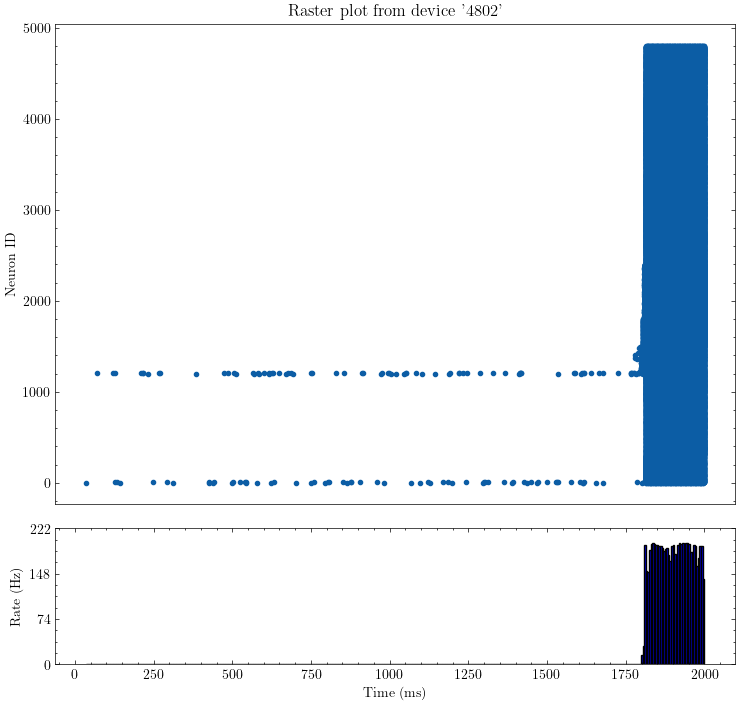

In [ ]:
nest.raster_plot.from_device(spikes_E, hist=True)